# Can We Predict Tomorrow's Snow?: A Data-Driven Approach
## Team Info
*Name:* Yeojin Kim     
*E-mail:* u1375950@utah.edu    
*UID:* u1375950

*Name:*    Daniel Collins   
*E-mail:*   u1513590@utah.edu   
*UID:* u1513590  

*Name:*     Hugo Hoyer   
*E-mail:*   u1505072@utah.edu   
*UID:*  u1505072

# Collecting and Storing the Data
After determining the [website](https://weatherstack.com/) we were going to use for the weather data, we needed to store ten years of weather data in a csv file.

In [1]:
import requests 
import pandas as pd
import json

## Part 1: Practicing

Tested what a single API request looked like and used the result to expieriement on so that we didn't waste the limited requests we had available.

In [ ]:
url = "https://api.weatherstack.com/historical?access_key=3b38d4e26797a56261880014825a85a7"

querystring = {"query":"Salt Lake City", "historical_date":"2015-01-21", "hourly":1}

response = requests.get(url, params=querystring)

print(response.json())

Stored the response in json

In [ ]:
test2 = json.loads(response.content)
test2

Pulled the hourly data into a seperate variable. Tested whether storing each hours (8 per day) data was neccessary, decided to just keep the data from noon (time : 1200) for simplicity.

In [ ]:
hourly_data = test2['historical']['2015-01-21']['hourly']
hourly_data

## Part 2: Storing key values
As there were two sections of the json file that we needed (hourly and daily data), made two temporary pandas data frames that we merged into the final finished data frame. 
Tested various other options before settling on this version. 

(Kept the following panels as they were before the final revision was made in the actual API call.)

In [ ]:
dirty_hourly = pd.DataFrame(hourly_data)
hourly = dirty_hourly[['time','temperature','wind_speed','wind_degree','precip','humidity','visibility','pressure','cloudcover','heatindex','dewpoint','windchill','windgust','feelslike']]
test65 = pd.DataFrame(hourly.iloc[4]).T.reset_index()
test65

In [ ]:
daily_num = [test2['historical']['2015-01-21']['date'],test2['historical']['2015-01-21']['mintemp'], test2['historical']['2015-01-21']['maxtemp'], test2['historical']['2015-01-21']['avgtemp'], test2['historical']['2015-01-21']['sunhour'],test2['historical']['2015-01-21']['uv_index'],test2['historical']['2015-01-21']['totalsnow']]
daily = pd.DataFrame(daily_num, index=['date','mintemp','maxtemp','avgtemp','sunhour','uv_index','totalsnow']).T

In [ ]:
daily

## Part 3: Reducing Variables
At this point we have only kept the columns that we determined had a chance to be significant in determining possible snowfall. This included removing any non int/double column and all of the 'chanceof' columns as keeping any (especially chanceofsnow) would defeat the purpose of the analysis.

Below was the dataframe with each of the eight hours (time) still kept. 
While it was possible to extend the 'daily' variables into each of the eight rows, or create a higher dimensional dataframe, we determined that the extra data gained was not worth the added complexity that would be required to analysis data stored in either method.
Having each day stored on a single row, (as is the case with the final dataframe) makes exploratory analysis much quicker and easier to understand.

In [ ]:
final_df = pd.concat([daily, hourly], axis=1)
final_df

(testing adding a row to the bottom of the data frame to make sure it worked properly [before the large API request])

In [ ]:
final_df.loc[len(final_df)] = (final_df.loc[0])
final_df

## Part 4: Compiling the actual Dataframe
After testing and deciding on what we wanted in the finalized dataframe, we initialized an empty dataframe with the column names that we wanted to record.

In [ ]:
weather_df = pd.DataFrame(columns=['date','mintemp','maxtemp','avgtemp','sunhour','uv_index','totalsnow','index','time','temperature','wind_speed','wind_degree','precip','humidity','visibility','pressure','cloudcover','heatindex','dewpoint','windchill','windgust','feelslike'])
weather_df

Then we setup a loop to send API requests for the ten years we wanted data on (2015-2024) as well as the months that snowfall would be present (1-4,9-12). This left us with 2420 API requests to store in the DataFrame.

We then implemented the finalized testing code from above into each iteration of the loop and stored it in the previously empty weather_df (see comments in code for what each part does).

In [ ]:
months = ['01','02','03','04','09','10','11','12']
days = {'01':31,'02':28,'03':31,'04':30,'09':30,'10':31,'11':30,'12':31}
zero = ''
counter = 0
for year in range(2015,2025):
    for month in months:
        for day in range(1,days[month]+1):
            if(day < 10):
                zero = '0'+ str(day)
            else:
                zero = str(day)
            #Sets the querystring equal to the day. (Ignores leapdays)
            querystring = {"query":"Salt Lake City", "historical_date":f'{year}-{month}-{zero}', "hourly":1}
            response = requests.get(url, params=querystring)

            weather_json = json.loads(response.content)
            #Sets and cleans the data for hourly
            hourly_data = weather_json['historical'][f'{year}-{month}-{zero}']['hourly']
            dirty_hourly = pd.DataFrame(hourly_data)
            hourly = dirty_hourly[['time','temperature','wind_speed','wind_degree','precip','humidity','visibility','pressure','cloudcover','heatindex','dewpoint','windchill','windgust','feelslike']]
            hour = pd.DataFrame(hourly.iloc[4]).T.reset_index()
            #Sets and cleans the data for daily
            daily_num = [weather_json['historical'][f'{year}-{month}-{zero}']['date'],weather_json['historical'][f'{year}-{month}-{zero}']['mintemp'], weather_json['historical'][f'{year}-{month}-{zero}']['maxtemp'], weather_json['historical'][f'{year}-{month}-{zero}']['avgtemp'], weather_json['historical'][f'{year}-{month}-{zero}']['sunhour'], weather_json['historical'][f'{year}-{month}-{zero}']['uv_index'], weather_json['historical'][f'{year}-{month}-{zero}']['totalsnow']]
            daily = pd.DataFrame(daily_num, index=['date','mintemp','maxtemp','avgtemp','sunhour','uv_index','totalsnow']).T
            #Joins the two
            joined = pd.concat([daily, hour], axis=1)
            #Adds to end of complete dataframe
            weather_df.loc[len(weather_df)] = (joined.loc[0])
            counter += 1
            print(f'API request #{counter}')

In [ ]:
#Dropped the no longer needed columns 'index' and 'hour' which were left over from concat
#weather_df.drop('index')
#weather_df.drop('hour')
weather_df

## Part 5: Saving as CSV file
Lastly after completing the weather_df DataFrame we download the finished result as a csv file.

In [ ]:
weather_df.to_csv('weather_df.csv', index = False)

# Cleaning the Data
Before we can fully analyze the weather data and come to any conclusions, we must first clean the data.

There are thousands of days in our dataset with no snowfall, as well as variables that really have no correlation with snow, so to help make our analysis simpler, we will get rid of all the unnecessary data.

## Part 1: Importing the Necessary Packages
The first thing we have to do is import all the packages we will need to clean the data.

We will import Pandas to put all of our data into a DataFrame.
<br>
We will import Seaborn to create heatmaps for visualization.
<br>
We will import Matplotlib to display our heatmaps.

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Part 2: Importing the Data
Now that we have our packages installed, we can load our data into a DataFrame, which we will use for our analysis.

In [3]:
weather = pd.read_csv('weather_df.csv')

print(weather.shape)
weather.head()

(2420, 22)


,date,mintemp,maxtemp,avgtemp,sunhour,uv_index,totalsnow,index,time,temperature,...,precip,humidity,visibility,pressure,cloudcover,heatindex,dewpoint,windchill,windgust,feelslike
0,2015-01-01,-15,-7,-11,10,2,0.0,4,1200,-7,...,0.0,73,10,1029,3,-7,-9,-11,13,-11
1,2015-01-02,-16,-4,-10,10,2,0.0,4,1200,-6,...,0.0,76,10,1029,10,-6,-7,-6,6,-6
2,2015-01-03,-12,-2,-7,10,2,0.0,4,1200,-2,...,0.0,76,10,1027,46,-2,-5,-3,9,-3
3,2015-01-04,-8,3,-3,10,2,0.0,4,1200,1,...,0.0,72,10,1031,48,1,-4,-2,20,-2
4,2015-01-05,-4,5,1,10,2,0.0,4,1200,4,...,0.0,82,10,1030,32,4,1,0,29,0


## Part 3: Initial Visualization
Now that our data has been loaded in, we can start analyzing it and narrowing it down to what we need.

First, we must get rid of the "date" column, as it is not in Float form.
<br>
Then, we can create a correlation heatmap to see what variables correlate the most with each other, and specifically with the "totalsnow" column.

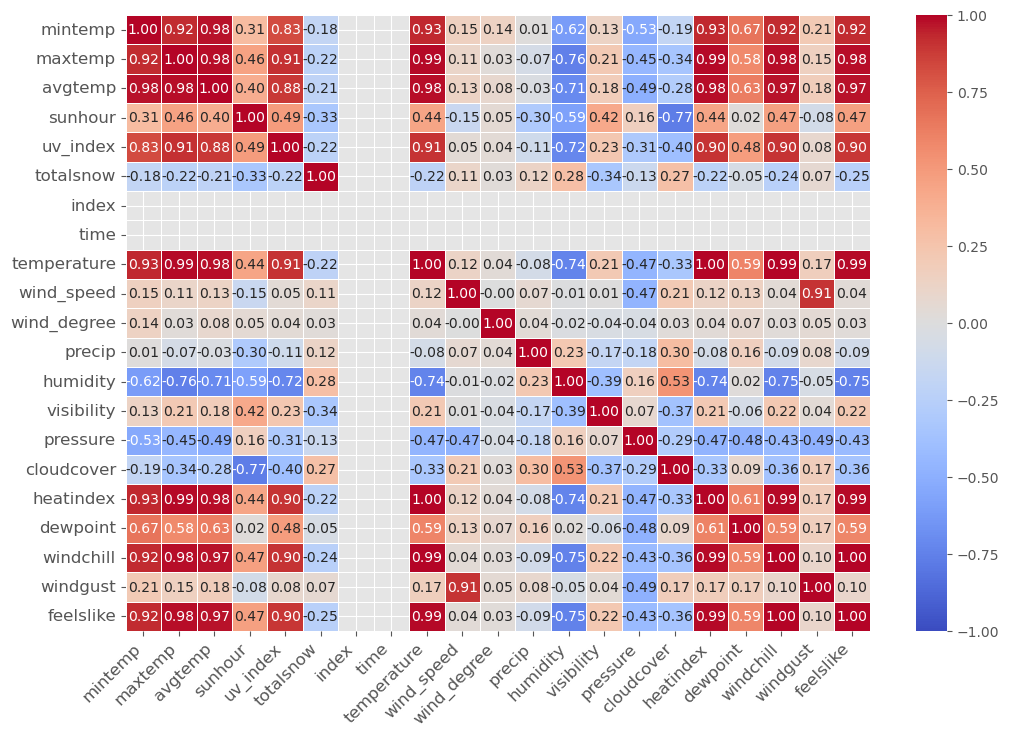

In [4]:
weather_no_date = weather.drop('date', axis=1)

weather_correlation = weather_no_date.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(weather_correlation, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

plt.show()

## Part 4: Filtering out Unnecessary Days
Up until this point, we have been working with the entire dataset, including all of the days with no snow.

To narrow down our dataset, we have chosen to only look at the days with snow, and the 2 days leading up to them.
<br>
This shortens our dataset from 2420 rows to just 511.

In [5]:
snow_indexes = weather_no_date.index[weather_no_date['totalsnow'] > 0]

keep_indexes = set()
for index in snow_indexes:
    keep_indexes.update([index, index - 1, index - 2])

keep_indexes = [i for i in keep_indexes if i in weather_no_date.index]

weather_filtered_rows = weather_no_date.loc[sorted(keep_indexes)]

print(weather_filtered_rows.shape)
weather_filtered_rows.head()

(479, 21)


,mintemp,maxtemp,avgtemp,sunhour,uv_index,totalsnow,index,time,temperature,wind_speed,...,precip,humidity,visibility,pressure,cloudcover,heatindex,dewpoint,windchill,windgust,feelslike
10,-1,6,3,10,1,0.0,4,1200,5,3,...,0.0,88,10,1020,73,5,3,5,10,5
11,0,5,3,10,2,0.0,4,1200,4,9,...,0.7,85,5,1021,54,4,2,1,14,1
12,-5,3,-1,8,1,1.4,4,1200,3,11,...,0.0,83,10,1028,33,3,0,-1,24,-1
59,-3,6,2,11,2,0.0,4,1200,6,4,...,0.3,55,10,1021,75,6,-3,5,11,5
60,-1,6,3,7,2,0.0,4,1200,5,6,...,0.4,65,10,1008,52,5,-1,4,11,4


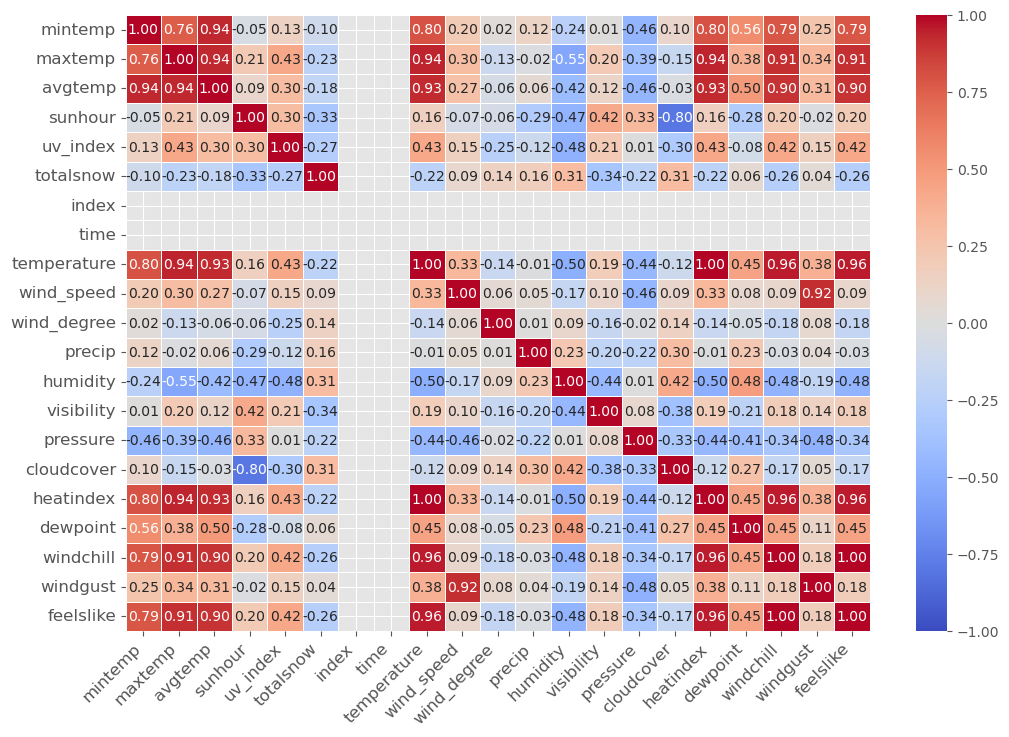

In [6]:
weather_filtered_rows_correlation = weather_filtered_rows.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(weather_filtered_rows_correlation, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

plt.show()

## Part 5: Filtering out Unnecessary Columns
Now that we have our correlation matrix based on just the days we are interested in, we can see which columns have little to no correlation with the "totalsnow" column.
<br>
We have chosen to eliminate all columns with a correlation of less than 0.2, which reduces the DataFrame from 20 columns to just 9.

In [7]:
snow_correlation = weather_filtered_rows.corr(numeric_only=True)['totalsnow']

strong_correlation_columns = snow_correlation[abs(snow_correlation) >= 0.2].index.tolist()

weather_filtered = weather_filtered_rows[strong_correlation_columns]

print(weather_filtered.shape)
weather_filtered.head()

(479, 12)


,maxtemp,sunhour,uv_index,totalsnow,temperature,humidity,visibility,pressure,cloudcover,heatindex,windchill,feelslike
10,6,10,1,0.0,5,88,10,1020,73,5,5,5
11,5,10,2,0.0,4,85,5,1021,54,4,1,1
12,3,8,1,1.4,3,83,10,1028,33,3,-1,-1
59,6,11,2,0.0,6,55,10,1021,75,6,5,5
60,6,7,2,0.0,5,65,10,1008,52,5,4,4


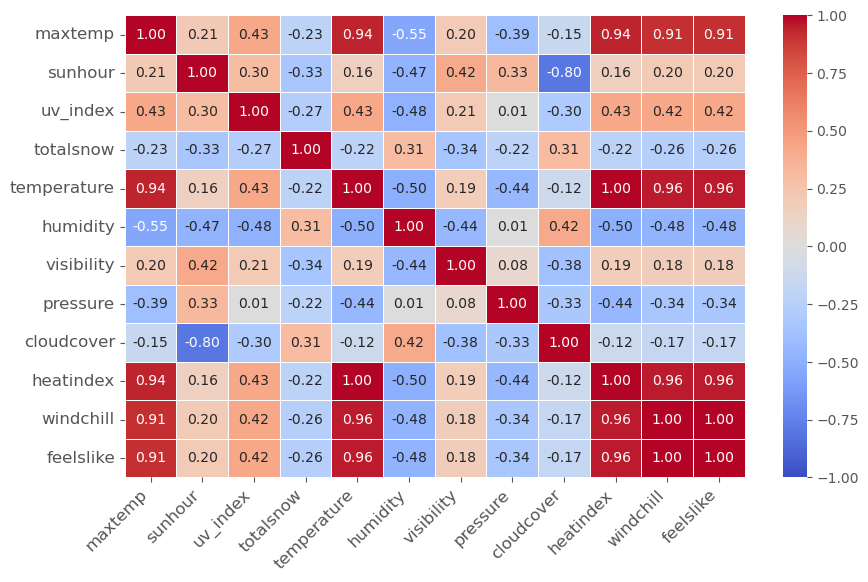

In [8]:
weather_filtered_correlation = weather_filtered.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(weather_filtered_correlation, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

plt.show()

# Exploratory Analysis
We will now analyize the data to determine which factors strongly predict next-day snowfall. 

## Part 1: Univariate Analysis
First, we will build histogram to visualize the distribution of each variable (like temperature, humidity, pressure, etc.) to understand their individual characteristics.

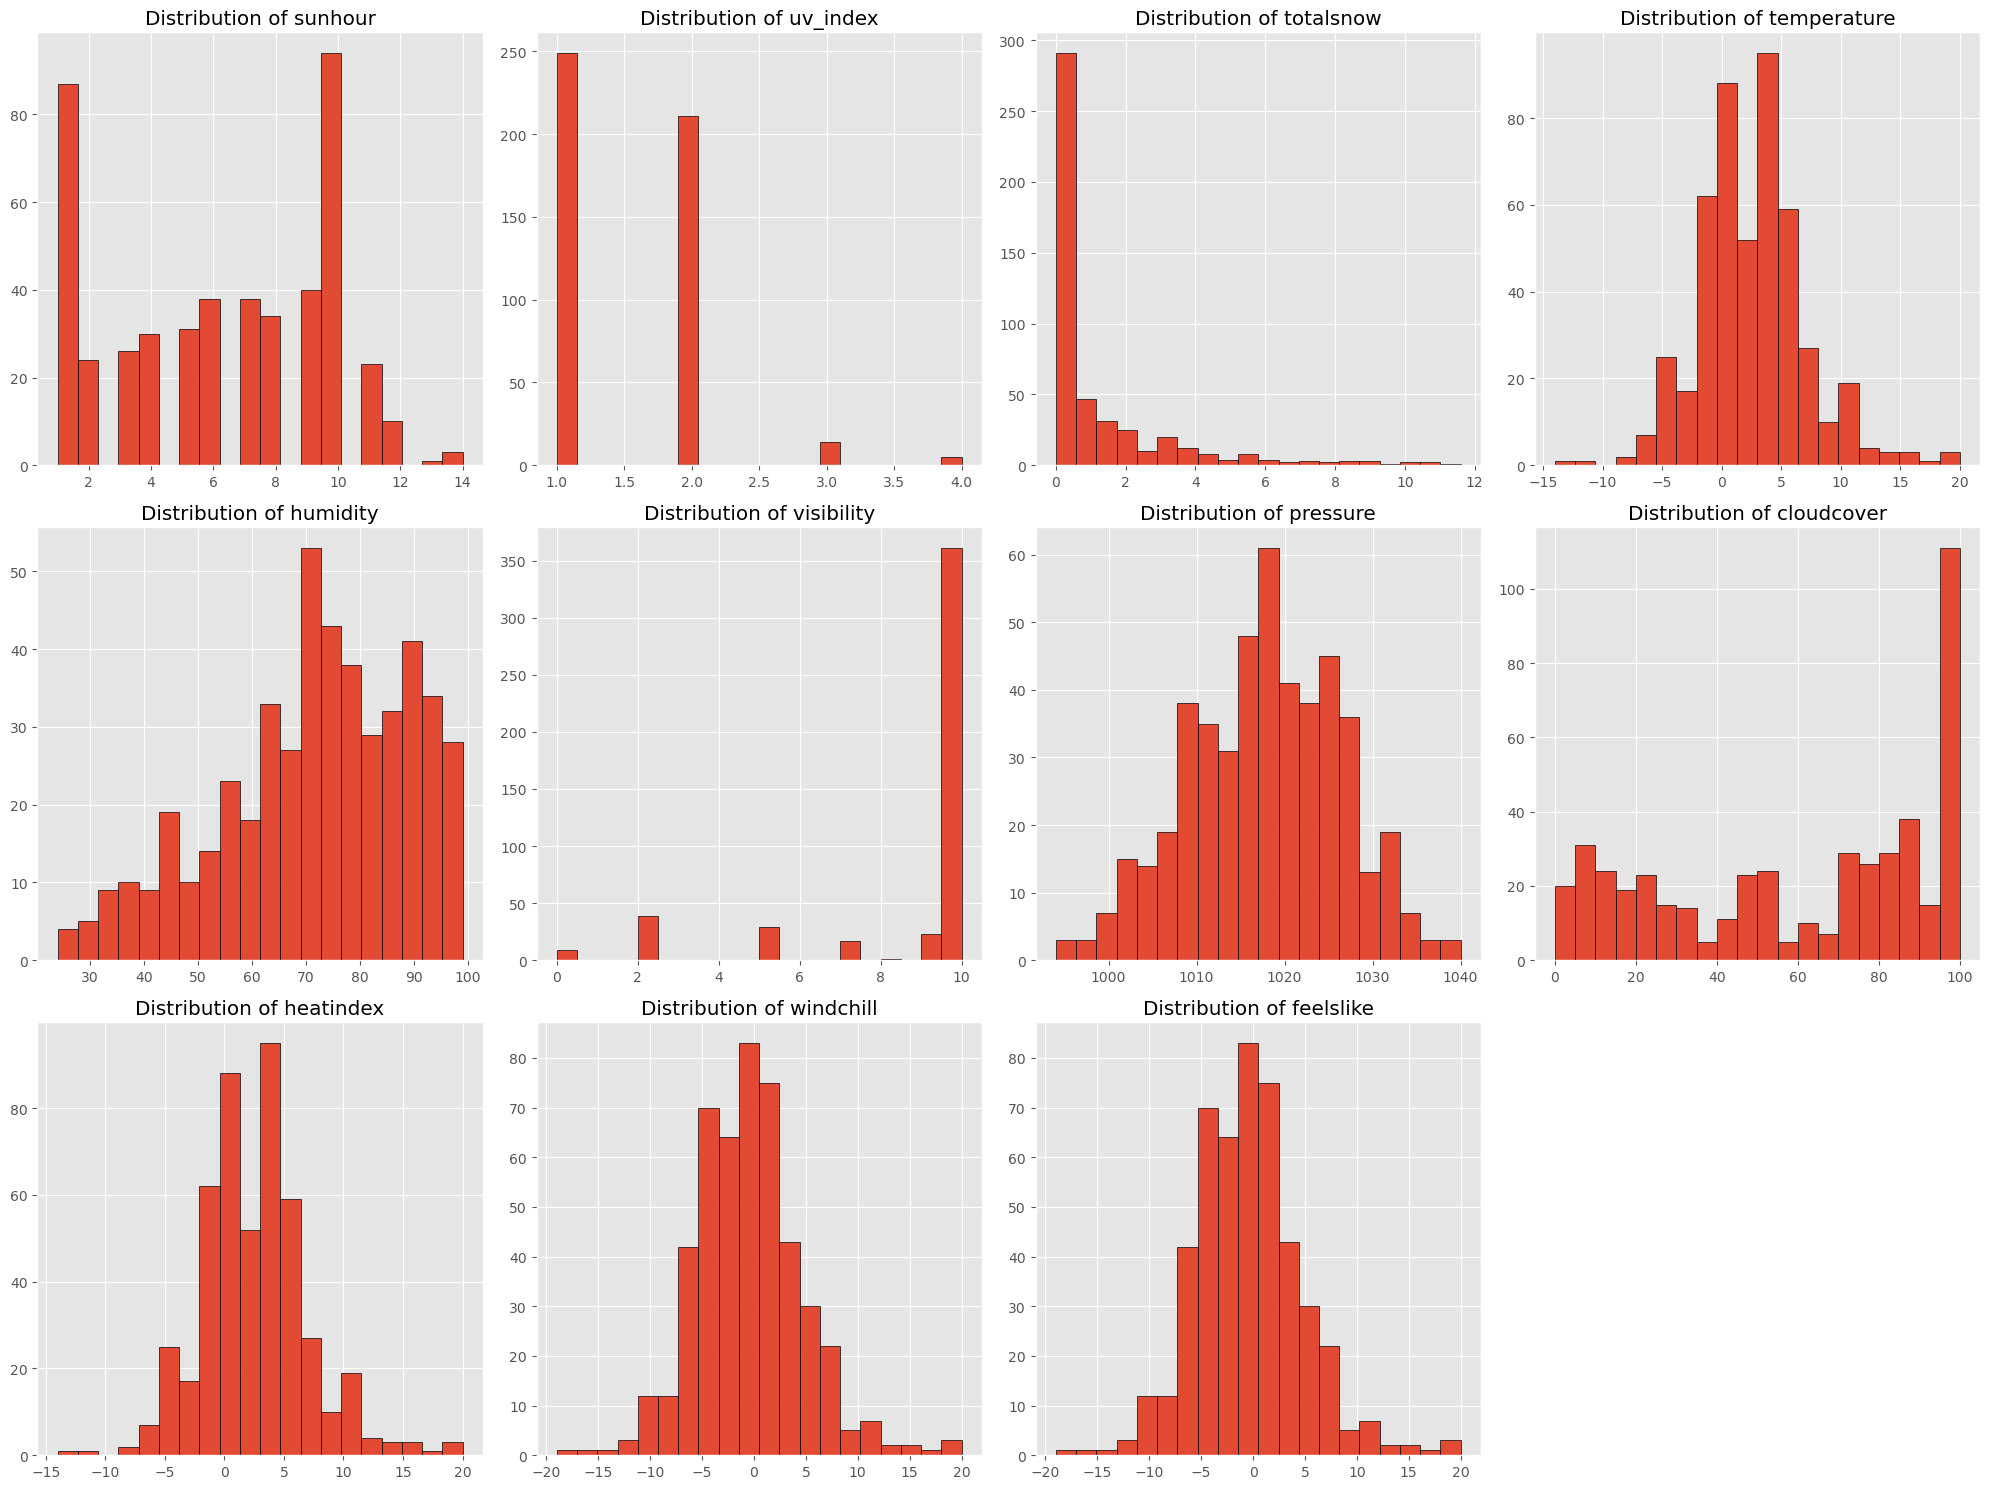

In [11]:
# Univariate Analysis: Histograms
plt.figure(figsize=(20, 15))
num_columns = len(weather_filtered.columns[1:])
rows = (num_columns // 4) + 1
for i, column in enumerate(weather_filtered.columns[1:], 1):
    plt.subplot(rows, 4, i)
    plt.hist(weather_filtered[column], bins=20, edgecolor='black')
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

## Part 2: Multivariate analysis
Next, for multivariate analysis, we can build correlation heatmap (Seaborn) to identify the relationships between variables and scatter plots to show pairwise relationships between selected variables.

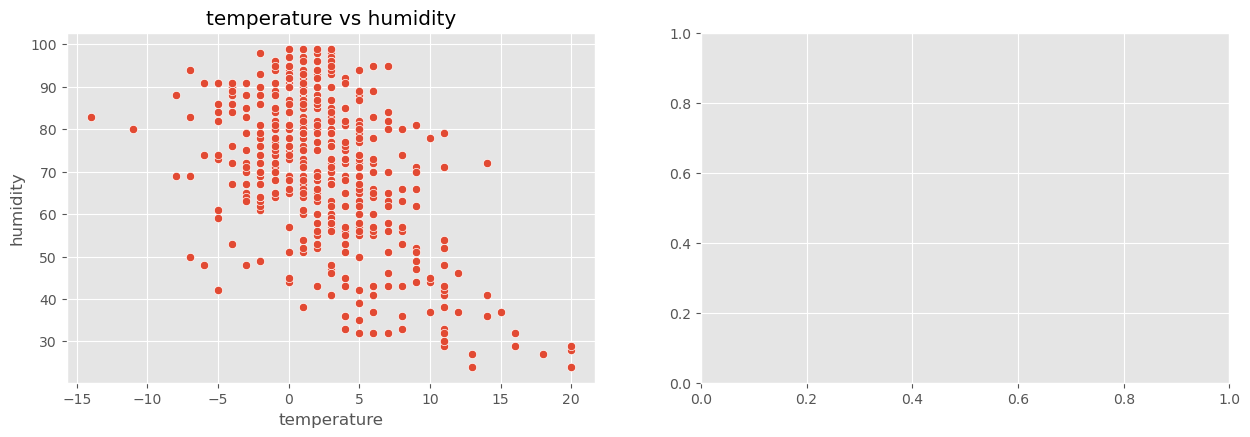

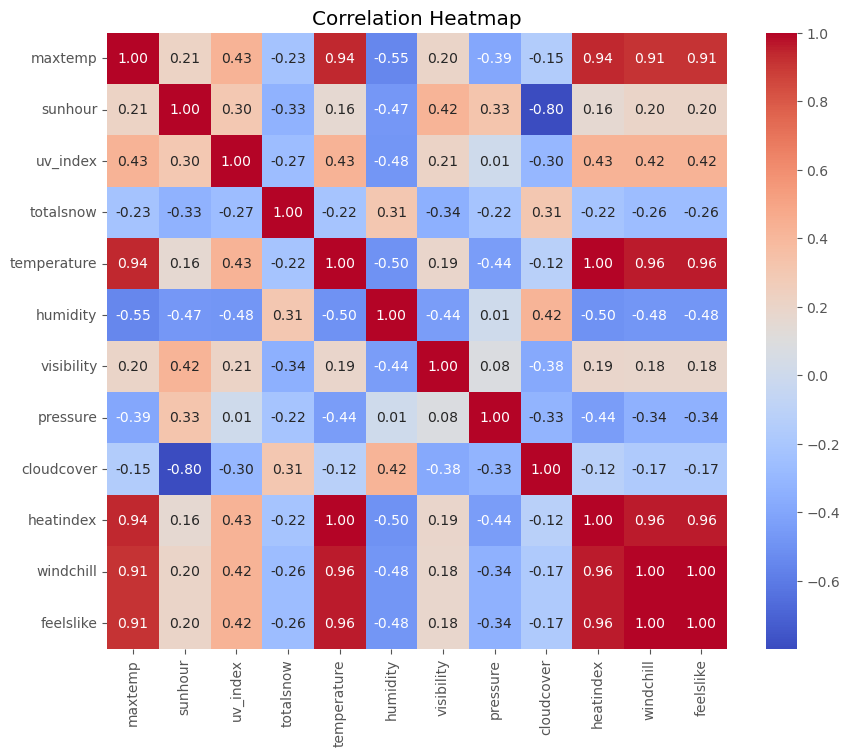

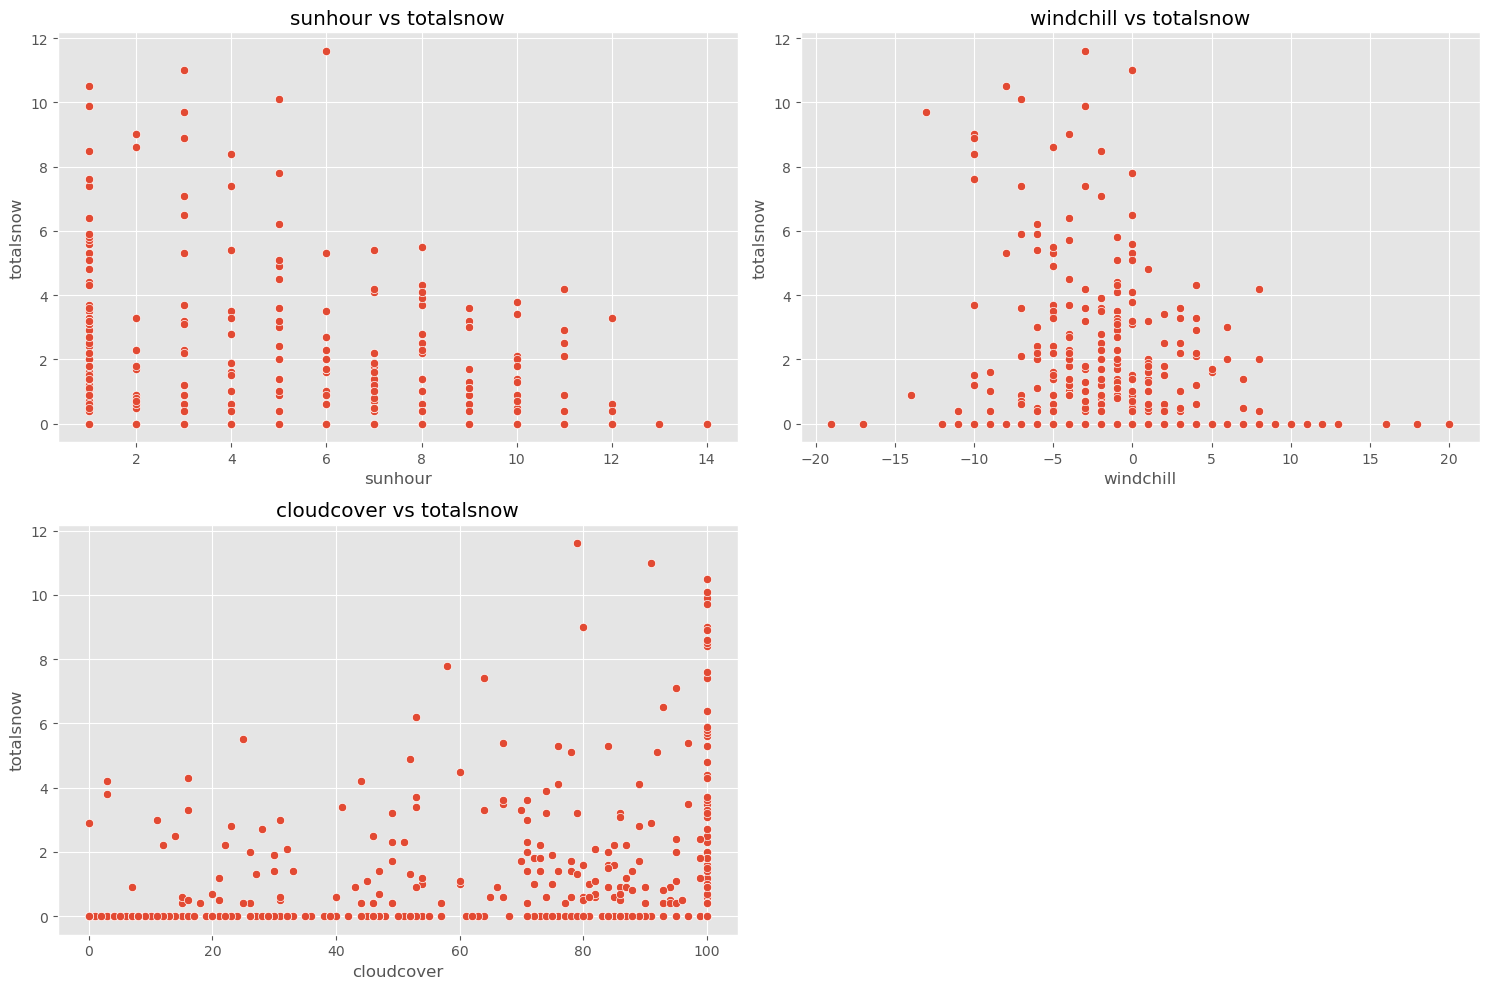

In [13]:
# Multivariate Analysis: Correlation Heatmap
plt.figure(figsize=(10, 8))
corr_matrix = weather_filtered.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Scatter Plots for Key Pairs
plt.figure(figsize=(15, 10))
key_pairs = [('sunhour', 'totalsnow'), ('windchill', 'totalsnow'), ('cloudcover', 'totalsnow')]
for i, (x, y) in enumerate(key_pairs, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(data=weather_filtered, x=x, y=y)
    plt.title(f'{x} vs {y}')
plt.tight_layout()
plt.show()

## Part 3: Statistical Testing
For the next step of our analysis, we will conduct statistical testing and build predictive models to investigate the relationship between weather variables and snowfall.
<br>
First, we will perform a T-test to determine whether there are statistically significant differences in key weather variables (such as temperature, humidity, and pressure) between days with snowfall and days without snowfall.

In [14]:
from scipy import stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [15]:
# Check if 'totalsnow' column exists and identify snowfall days
if 'totalsnow' in weather_filtered.columns:
    snowfall_days = weather_filtered[weather_filtered['totalsnow'] > 0]
    no_snowfall_days = weather_filtered[weather_filtered['totalsnow'] == 0]

    # Perform T-Test
    for col in ['temperature', 'humidity', 'pressure']:
        t_stat, p_value = stats.ttest_ind(snowfall_days[col], no_snowfall_days[col], nan_policy='omit')
        print(f'T-Test for {col} between snowfall and non-snowfall days: t-statistic = {t_stat}, p-value = {p_value}')
else:
    print("Error: 'totalsnow' column not found in the dataset.")

T-Test for temperature between snowfall and non-snowfall days: t-statistic = -5.431206500565527, p-value = 8.934963206480657e-08
T-Test for humidity between snowfall and non-snowfall days: t-statistic = 8.061536295063192, p-value = 6.1184128333512115e-15
T-Test for pressure between snowfall and non-snowfall days: t-statistic = -4.1403596125886795, p-value = 4.1008443539365925e-05


## Part 4: Predictive Models
Next, we will build regression models to predict next-day snowfall. A simple linear regression model will be used to explore the linear relationship between individual weather variables and snowfall. Additionally, we will construct a logistic regression model to predict the likelihood of snowfall based on multiple weather conditions.

In [18]:
# Simple Linear Regression Model (if 'totalsnow' is defined)
if 'totalsnow' in weather_filtered.columns:
    X = weather_filtered[['temperature', 'humidity', 'pressure']]
    y = weather_filtered['totalsnow']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    print("Linear Regression Coefficients:", model.coef_)

# Logistic Regression for Snowfall Prediction using 'totalsnow'
if 'totalsnow' in weather_filtered.columns:
    X = weather_filtered[['temperature', 'humidity', 'pressure']]
    y = (weather_filtered['totalsnow'] > 0).astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    log_model = LogisticRegression()
    log_model.fit(X_train, y_train)
    y_pred = log_model.predict(X_test)
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

Linear Regression Coefficients: [-0.13235314  0.01415207 -0.0833912 ]
Accuracy: 0.7291666666666666
              precision    recall  f1-score   support

           0       0.79      0.72      0.75        82
           1       0.67      0.74      0.70        62

    accuracy                           0.73       144
   macro avg       0.73      0.73      0.73       144
weighted avg       0.73      0.73      0.73       144



# Project Schedule
Apr 3rd - Task allocation for Project Presentation
<br>
Apr 15th - Midway check
<br>
Apr 17th - Final meeting before Project Presentation